## Introduction

This notebook and the notebooks in this folder are all aimed at transpiling the cloning circuit into native gates for the IonQ QPU. One of the challenges in doing so is the problem of debugging; it is difficult to check that two circuits (one in Qiskit gates and one in IonQ native gates) are producing equivalent results. To obviate this difficulty we introduce intermediate steps where we convert first into $R_{x}, R_{y}$, and $R_{xx}$ gates, all of which can be easily implemented in Qiskit. This gives us a simple way of manipulating the circuit as we would in standard transpilation steps (following Maslov, for instance) and track the output using Qiskit gates. At the end we will be able to translate the Qiskit circuit into the IonQ native gates.

#### The $R_{xx}$ Gate

In Qiskit the $R_{xx}(\theta)$ gate has the following matrix representation:
$$
R_{xx}(\theta) = \left ( 
\begin{matrix}
\cos(\theta/2) & 0 & 0 & -i \sin(\theta/2)\\
0 & \cos(\theta/2) & -i \sin(\theta/2) & 0\\
0 & -i \sin(\theta/2) & \cos(\theta/2) & 0\\
-i \sin(\theta/2) & 0 & 0 & \cos(\theta/2)
\end{matrix}
\right )
$$
A key gate in Maslov's paper is the $XX(\cdot)$ gate which corresponds to the $R_{xx}$ gate above according to $R_{xx}(\theta) = XX(\theta/2)$. IonQ implements these gates using their $MS(\phi_{0}, \phi_{1})$ gate; the matrix representation of the $MS(\cdot, \cdot)$ gate is more complicated, but the important case for our work is that $R_{xx}(\pi/2) = MS(0,0)$.

#### Phase Covariance on Equatorial Qubits

We have transpiled our circuit several times now and recently observed a lack of phase covariance in the circuit. A key focus of the notebooks in this series will be the testing of phase covariance for the converted circuits. The phase covariance property for our original circuit implementation has been demonstrated in another notebook.


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
def equatorial_prep(qc, phi):
    qc.h(0)
    qc.rz(phi, 0)
    return qc

In [3]:
def equatorial_measurement_prep(qc, phi):
    qc.rz(-phi,0)
    qc.h(0)
    
    qc.rz(-phi,1)
    qc.h(1)
    
    qc.rz(-phi,2)
    qc.h(2)
    
    return qc

In [5]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/shots
        E = (out010 + out011 + out110 + out111)/shots
        A = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/shots
        E = (out001 + out000 + out101 + out100)/shots
        A = (out000 + out001 + out010 + out011)/shots
        
    return B,E,A 

In [6]:
def rxx_cloning(qc, theta2):
    
    qc.ry(np.pi, 1)
    qc.rxx(np.pi/2, 1, 2)
    qc.rx(-np.pi/2, 1)
    qc.rx(-np.pi/2, 2)
    qc.ry(-np.pi/2, 1)
    
    qc.barrier()
    
    qc.ry(2*theta2 + np.pi/2, 2)
    qc.rxx(np.pi/2, 2, 1)
    qc.rx(-np.pi/2, 2)
    qc.rx(-np.pi/2, 1)
    qc.ry(-np.pi/2, 2)
    
    qc.barrier()
    
    qc.ry(2*theta2, 1) # theta2 =theta3
    
    qc.barrier()
    
    qc.ry(np.pi/2, 0)
    qc.rxx(np.pi/2, 0, 1)
    qc.rx(-np.pi/2, 0)
    qc.rx(-np.pi/2, 1)
    
    qc.barrier()
    
    qc.rxx(np.pi/2, 0, 2)
    qc.rx(-np.pi/2, 0)
    qc.rx(-np.pi/2, 2)
    qc.ry(-np.pi/2, 0)
    
    qc.barrier()
    
    qc.ry(np.pi/2, 1)
    qc.rxx(np.pi/2, 1,0)
    qc.rx(-np.pi/2, 0)
    qc.rx(-np.pi/2, 1)
    qc.ry(-np.pi/2, 1)
    
    qc.barrier()
    
    qc.ry(np.pi/2, 2)
    qc.rxx(np.pi/2, 2, 0)
    qc.rx(-np.pi/2, 2)
    qc.rx(-np.pi/2, 0)
    qc.ry(-np.pi/2, 2)
    
    return qc

In [7]:
def equatorial_cloner(theta2, phi):
    qc = QuantumCircuit(3,3)
    
    qc = equatorial_prep(qc, phi)
    qc.barrier()
    
    qc = rxx_cloning(qc, theta2)
    qc.barrier()
    
    qc = equatorial_measurement_prep(qc, phi)
    qc.barrier()
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    return qc
    
    

In [16]:
def phase_covariance(theta2, phi, shots):
        
    qc = equatorial_cloner(theta2, phi)
    
    shots = 1024 # number of samples used for statistics
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend = sim, shots = shots)
    
    out000 = job.result().get_counts().get("000")
    out001 = job.result().get_counts().get("001")
    out010 = job.result().get_counts().get("010")
    out011 = job.result().get_counts().get("011")
    out100 = job.result().get_counts().get("100")
    out101 = job.result().get_counts().get("101")
    out110 = job.result().get_counts().get("110")
    out111 = job.result().get_counts().get("111")

    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
    
    
    B,E,A = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, 0, shots)
    
    #return B,E,A, qc
    return B,E,A

In [15]:
b,e,a, qc = phase_covariance(np.pi/8, 0, 1024)
qc.draw()

┌───┐┌───────┐ ░                                                ░ »
q_0: ┤ H ├┤ Rz(0) ├─░────────────────────────────────────────────────░─»
     └───┘└───────┘ ░ ┌───────┐┌───────────┐┌──────────┐┌──────────┐ ░ »
q_1: ───────────────░─┤ Ry(π) ├┤0          ├┤ Rx(-π/2) ├┤ Ry(-π/2) ├─░─»
                    ░ └───────┘│  Rxx(π/2) │├──────────┤└──────────┘ ░ »
q_2: ───────────────░──────────┤1          ├┤ Rx(-π/2) ├─────────────░─»
                    ░          └───────────┘└──────────┘             ░ »
c: 3/══════════════════════════════════════════════════════════════════»
                                                                       »
«                                                       ░             ░ »
«q_0: ──────────────────────────────────────────────────░─────────────░─»
«                 ┌───────────┐┌──────────┐             ░ ┌─────────┐ ░ »
«q_1: ────────────┤1          ├┤ Rx(-π/2) ├─────────────░─┤ Ry(π/4) ├─░─»
«     ┌──────────┐│  Rxx(π/2) │├──────────┤┌──────────┐ ░ └─────────┘ ░ »
«q_2: ┤ Ry(3π/4) ├┤0          ├┤ Rx(-π/2) ├┤ Ry(-π/2) ├─░─────────────░─»
«     └──────────┘└───────────┘└──────────┘└──────────┘ ░             ░ »
«c: 3/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌─────────┐┌───────────┐┌──────────┐ ░ ┌───────────┐┌──────────┐»
«q_0: ┤ Ry(π/2) ├┤0          ├┤ Rx(-π/2) ├─░─┤0          ├┤ Rx(-π/2) ├»
«     └─────────┘│  Rxx(π/2) │├──────────┤ ░ │           │└──────────┘»
«q_1: ───────────┤1          ├┤ Rx(-π/2) ├─░─┤  Rxx(π/2) ├────────────»
«                └───────────┘└──────────┘ ░ │           │┌──────────┐»
«q_2: ─────────────────────────────────────░─┤1          ├┤ Rx(-π/2) ├»
«                                          ░ └───────────┘└──────────┘»
«c: 3/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌──────────┐ ░            ┌───────────┐┌──────────┐             ░ »
«q_0: ┤ Ry(-π/2) ├─░────────────┤1          ├┤ Rx(-π/2) ├─────────────░─»
«     └──────────┘ ░ ┌─────────┐│  Rxx(π/2) │├──────────┤┌──────────┐ ░ »
«q_1: ─────────────░─┤ Ry(π/2) ├┤0          ├┤ Rx(-π/2) ├┤ Ry(-π/2) ├─░─»
«                  ░ └─────────┘└───────────┘└──────────┘└──────────┘ ░ »
«q_2: ─────────────░──────────────────────────────────────────────────░─»
«                  ░                                                  ░ »
«c: 3/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                ┌───────────┐┌──────────┐             ░ ┌───────┐┌───┐ ░ ┌─┐»
«q_0: ───────────┤1          ├┤ Rx(-π/2) ├─────────────░─┤ Rz(0) ├┤ H ├─░─┤M├»
«                │           │└──────────┘             ░ ├───────┤├───┤ ░ └╥┘»
«q_1: ───────────┤  Rxx(π/2) ├─────────────────────────░─┤ Rz(0) ├┤ H ├─░──╫─»
«     ┌─────────┐│           │┌──────────┐┌──────────┐ ░ ├───────┤├───┤ ░  ║ »
«q_2: ┤ Ry(π/2) ├┤0          ├┤ Rx(-π/2) ├┤ Ry(-π/2) ├─░─┤ Rz(0) ├┤ H ├─░──╫─»
«     └─────────┘└───────────┘└──────────┘└──────────┘ ░ └───────┘└───┘ ░  ║ »
«c: 3/═════════════════════════════════════════════════════════════════════╩═»
«                                                                          0 »
«           
«q_0: ──────
«     ┌─┐   
«q_1: ┤M├───
«     └╥┘┌─┐
«q_2: ─╫─┤M├
«      ║ └╥┘
«c: 3/═╩══╩═
«      1  2

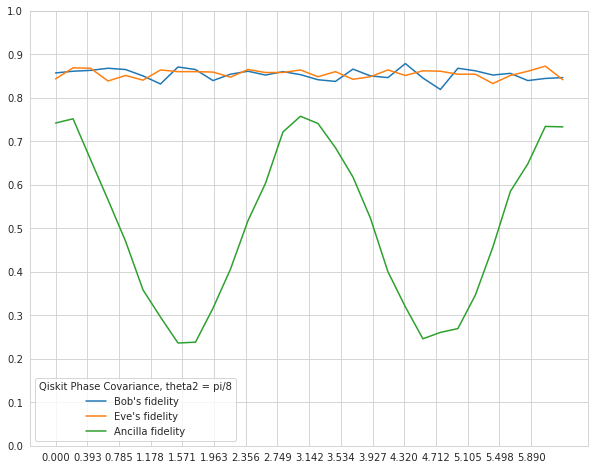

In [17]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance(np.pi/8, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="Qiskit Phase Covariance, theta2 = pi/8")
plt.show()

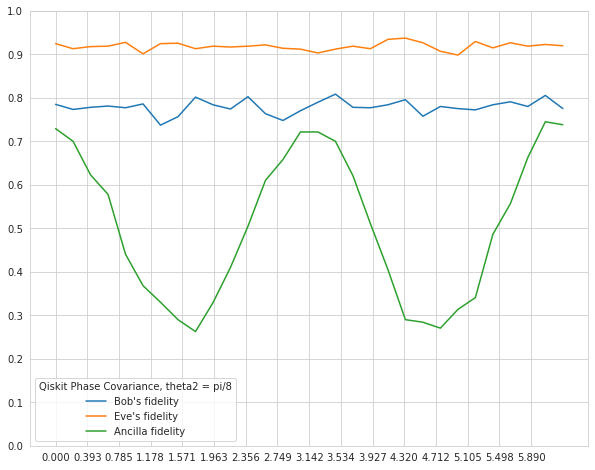

In [18]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance(np.pi/8 - 0.1, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="Qiskit Phase Covariance, theta2 = pi/8")
plt.show()

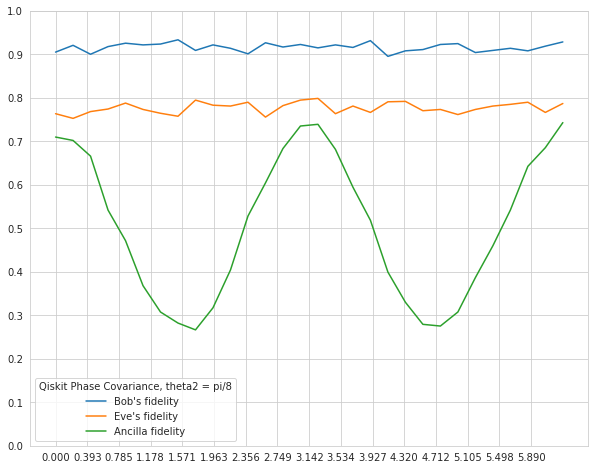

In [19]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance(np.pi/8 + 0.1, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="Qiskit Phase Covariance, theta2 = pi/8")
plt.show()